In [1]:
import os
os.environ['WANDB_DISABLED'] = 'true'
import pandas as pd
import numpy as np
import torch
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from datasets import Dataset
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    set_seed)

2025-10-16 07:05:09.838421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760598310.068500      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760598310.132400      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
RS = 42

os.environ['PYTHONHASHSEED'] = str(RS)
random.seed(RS)
np.random.seed(RS)

torch.manual_seed(RS)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RS)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(RS)

## Сборка одного датасета + предобработка данных

У нас есть два датасета: датасет с комментариями на русском языке и датасет с комментариями на английском языке. Мы объединяем их в один датасет и будем обучать модель на объединенном датасете, поскольку нам удобнее обучать и использовать на выходе одну модель, а не две (в первую очередь в силу ограниченности наших ресурсов).

Исследовательский анализ датасетов находится в другом ноутбуке (здесь представлена только краткая информация).
Важно отметить, что по заданию мы должны предсказывать 3 типа комментариев, а в датасетах было представлено от 4 до 6 меток. Мы вручную преобразовали исходные метки в датасетах в нужные нам типы комментариев согласно их смыслу.

In [3]:
eng_df = pd.read_csv('/kaggle/input/raw-datasets/toxic_train_df.csv')
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
eng_df['neutral'] = (eng_df[cols].sum(axis=1) == 0).astype(int)

# оскорбительные, но без угрозы
insult_cols = ['insult', 'toxic', 'obscene', 'identity_hate', 'severe_toxic']

# с угрозой
toxic_cols = ['threat']

In [4]:
eng_df['toxic_threat'] = (eng_df[toxic_cols].any(axis=1)).astype(int)
eng_df['toxic_not_threat'] = (
    (eng_df[insult_cols].any(axis=1)) & (eng_df['toxic_threat'] == 0)).astype(int)

In [5]:
eng_df[(eng_df['toxic_not_threat'] == 1) & (eng_df['threat'] == 1)]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,toxic_threat,toxic_not_threat


In [6]:
eng_df['labels'] = (
    eng_df['neutral'] * 0 + eng_df['toxic_threat'] * 1 + eng_df['toxic_not_threat'] * 2)
eng_df.rename(columns={'comment_text': 'text'}, inplace=True)

In [7]:
rus_df = pd.read_csv('/kaggle/input/raw-datasets/toxic_dataset_df.txt', sep='\t', header=None)
rus_df.columns = ['text']
rus_df['neutral'] = rus_df['text'].str.contains('NORMAL').astype(int)
rus_df['toxic_threat'] = rus_df['text'].str.contains('THREAT').astype(int)
rus_df['toxic_not_threat'] = (
    rus_df[['neutral', 'toxic_threat']].sum(axis=1) == 0).astype(int)

In [8]:
rus_df[(rus_df['toxic_threat'] == 1) & (rus_df['toxic_not_threat'] == 1)]

,text,neutral,toxic_threat,toxic_not_threat


In [9]:
labels_to_remove = ['__label__NORMAL', '__label__INSULT', '__label__THREAT', '__label__OBSCENITY']

for lbl in labels_to_remove:
    rus_df['text'] = rus_df['text'].str.replace(lbl + ',', '', regex=False)
    rus_df['text'] = rus_df['text'].str.replace(lbl, '', regex=False)

rus_df['text'] = rus_df['text'].str.replace(r'\s+', ' ', regex=True)
rus_df['text'] = rus_df['text'].str.strip(' ,')

In [10]:
rus_df['labels'] = (
    rus_df['neutral'] * 0 + rus_df['toxic_threat'] * 1 + rus_df['toxic_not_threat'] * 2)

Поскольку у нашей команды нет локальных GPU, модель мы будем обучать на Kaggle. Обучение на полном датасете (русский + английский) занимает более 8 часов, тогда как время одной непрерывной сессии должно быть менее 8 часов, иначе сессия принудительно прерывается, вследствие чего мы пришли к необходимости брать в обучение и тестирование только половину датасета.

In [11]:
rus_df['lang'] = 'ru'
eng_df['lang'] = 'en'
full_df = pd.concat(
    [rus_df[['text', 'labels', 'lang']], eng_df[['text', 'labels', 'lang']]],
    ignore_index=True)

full_df['text'] = full_df['text'].str.replace(r'[\n\r\t]+', ' ', regex=True)
full_df['text'] = full_df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

strata = full_df['labels'].astype(str) + '_' + full_df['lang']

X = full_df['text']
y = full_df['labels']

X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, full_df.index,
    train_size=0.4,
    test_size=0.1,
    random_state=42,
    stratify=strata)

train_df = full_df.loc[train_idx].reset_index(drop=True)
test_df = full_df.loc[test_idx].reset_index(drop=True)

## Обучение трансформера с huggingface

Берем модель с huggingface на базе дистиллированного берта, обученную на определении токсичности в разговорной речи, и будем обучать ее на своем датасете.
Было протестировано несколько моделей, в настоящем ноутбуке представлена информация по модели, которая показала наилучшие метрики на наших данных.

In [12]:
PATH = '/kaggle/working/results'
MODEL = 'citizenlab/distilbert-base-multilingual-cased-toxicity'

# обрезаем так, потому что комменты чаще всего недлинные + чтоб быстрее обучалось
TRUNC = 256

In [13]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Проводим токенизацию.

In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, model_max_length=TRUNC)

def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True)

train_dataset = train_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/163144 [00:00<?, ? examples/s]

Map:   0%|          | 0/40787 [00:00<?, ? examples/s]

Определяем словари, конфигурацию и модель, меняем классификационную голову на 3 класса, которые у нас по заданию. Обучать будем все слои модели, поскольку при замораживании слоев метрики получаются хуже.

In [15]:
n_classes = int(train_df['labels'].nunique())
id2label = {i: str(i) for i in range(n_classes)}
label2id = {v: k for k, v in id2label.items()}

config = AutoConfig.from_pretrained(
    MODEL,
    num_labels=n_classes,
    id2label=id2label,
    label2id=label2id,
    problem_type='single_label_classification')

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    config=config,
    ignore_mismatched_sizes=True).to(device)

config.json:   0%|          | 0.00/774 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/541M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at citizenlab/distilbert-base-multilingual-cased-toxicity and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Для обучения в результате ручного подбора выбраны такие гиперпараметры для того, чтобы код успел выполниться за менее чем 8 часов (т.к. это максимальное время непрерывной сессии на kaggle).

In [16]:
params = TrainingArguments(
    output_dir=PATH,
    learning_rate=1.5e-5,
    num_train_epochs=4,
    weight_decay=0.12,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    seed=RS,
    report_to=None,
    save_strategy='no',
    disable_tqdm=False)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Определяем веса для классов. Т.к. у нас значительный дисбаланс, берем 'balanced'.

In [17]:
classes_for_weights = np.arange(n_classes)
class_weights = torch.tensor(
    compute_class_weight(
        class_weight='balanced',
        classes=classes_for_weights,
        y=train_df['labels'].values),
    dtype=torch.float32,
    device=device)

Пишем класс для обучения.

In [18]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.criterion = nn.CrossEntropyLoss(weight=self.class_weights)

    def compute_loss(
        self,
        model,
        inputs,
        return_outputs: bool = False,
        num_items_in_batch: int | None = None,
        **kwargs):
        labels = inputs.pop('labels')
        if labels.dtype != torch.long:
            labels = labels.long()

        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.criterion(logits, labels)
        return (loss, outputs) if return_outputs else loss

Обучаем модель.

In [19]:
trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=params,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator)

trainer.train()

os.makedirs(PATH, exist_ok=True)
trainer.save_model(PATH)

/tmp/ipykernel_36/410964477.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
500,0.676000
1000,0.554200
1500,0.518700
2000,0.498600
2500,0.494300
3000,0.465800
3500,0.458900
4000,0.439400
4500,0.481400
5000,0.463800


Получаем предсказания и смотрим основные метрики.

In [20]:
pred = trainer.predict(test_dataset)
probs = torch.softmax(torch.tensor(pred.predictions), dim=-1).cpu().numpy()
pred_labels = probs.argmax(axis=1)

w_f1 = metrics.f1_score(test_df['labels'], pred_labels, average='weighted')
acc = metrics.accuracy_score(test_df['labels'], pred_labels)
print(f'Weighted F1 on test: {w_f1:.4f}')
print(f'Accuracy on test: {acc:.4f}')

Weighted F1 on test: 0.9636
Accuracy on test: 0.9636


Сохраняем предсказания на случай, если захотим их проанализировать отдельно.

In [21]:
pd.DataFrame(
    probs, index=test_df.index, columns=[id2label[i] for i in range(n_classes)]
).to_csv(f'{PATH}/predict.csv', index=False)
pd.Series(pred_labels, index=test_df.index, name='predict').to_csv(f'{PATH}/predict_labels.csv')

Строим матрицу ошибок, чтобы посмотреть, на чем модель ошибается и как сильно.

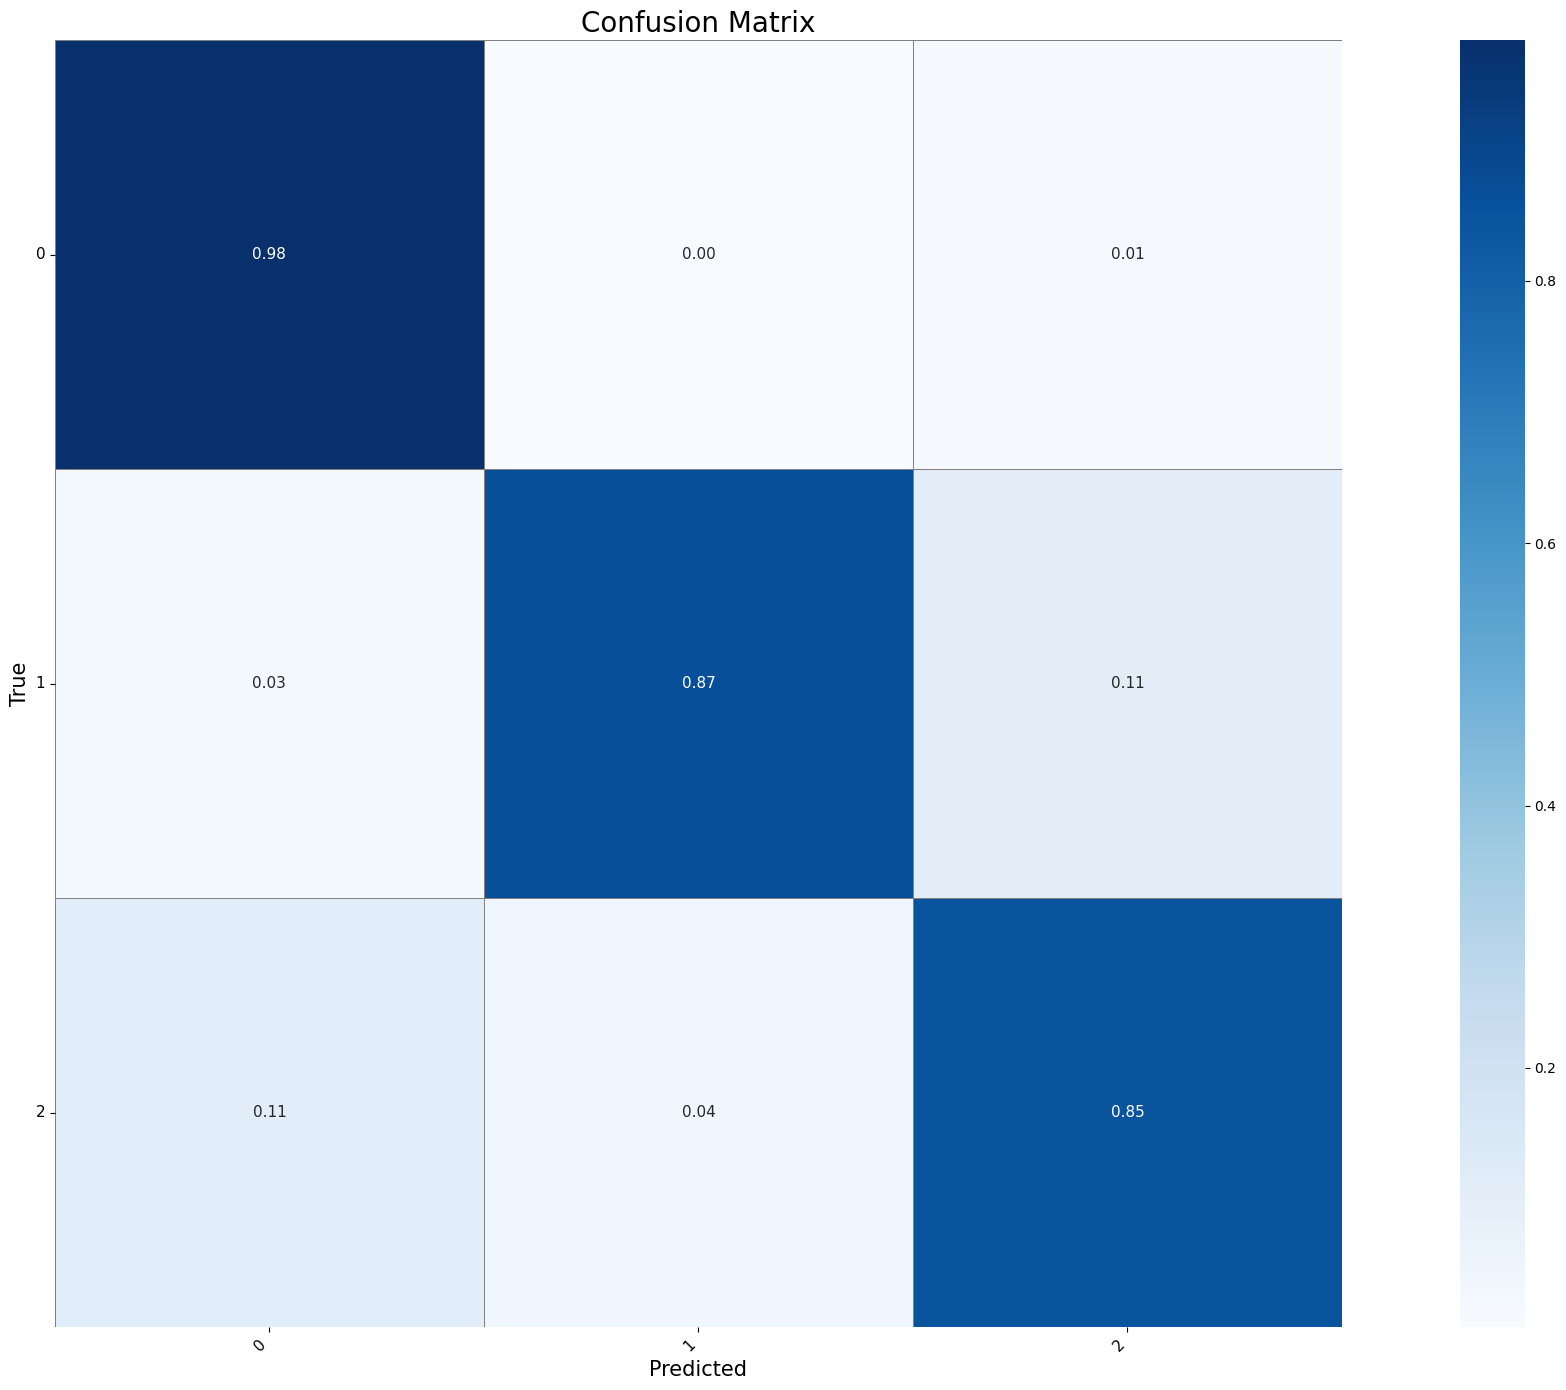

In [22]:
def plot_confusion_matrix(y_true, y_pred, id2label, title='Confusion Matrix', line=False, font_size=11):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    numeric_labels = sorted(np.unique(y_true))
    category_names = [id2label[i] for i in numeric_labels]

    cfm = confusion_matrix(y_true, y_pred, labels=numeric_labels).astype(float)
    cfm = cfm / cfm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(24, 4) if line is not False else (24, 14))
    if line is not False:
        acc = np.diag(cfm).reshape(1, -1)
        g = sns.heatmap(
            acc, annot=True, fmt='.2f', linewidths=.5, cmap='Blues', linecolor='grey',
            annot_kws={'size': font_size}, vmin=line, vmax=1.0,
            xticklabels=category_names, yticklabels=['Accuracy'])
        plt.xlabel('Category', size=font_size+4)
        plt.ylabel('', size=font_size+4)
    else:
        g = sns.heatmap(
            cfm, annot=True, fmt='.2f', linewidths=.5, square=True, cmap='Blues', linecolor='grey',
            annot_kws={'size': font_size}, xticklabels=category_names, yticklabels=category_names)
        plt.xlabel('Predicted', size=font_size+4)
        plt.ylabel('True', size=font_size+4)

    g.set_xticklabels(g.get_xmajorticklabels(), fontsize=font_size, rotation=45, ha='right')
    g.set_yticklabels(g.get_ymajorticklabels(), fontsize=font_size, rotation=0)
    plt.title(title, size=font_size+9)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(test_df['labels'], pred_labels, id2label, title='Confusion Matrix')

##### neutral = 0, toxic_threat = 1, toxic_not_threat = 2
Видим, что лучше всего модель предсказывает нейтральные комментарии, что логично, ведь комментариев такого типа в датасете больше всего. Комментариев типа toxic_threat и toxic_not_threat гораздо меньше, и их модель предсказывает хуже (иногда путает toxic_threat и toxic_not_threat, а также toxic_not_threat и neutral), однако метрика точности по-прежнему довольно высокая.